In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches

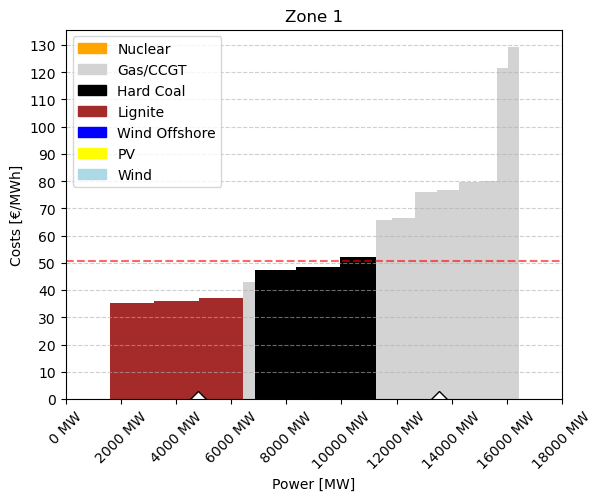

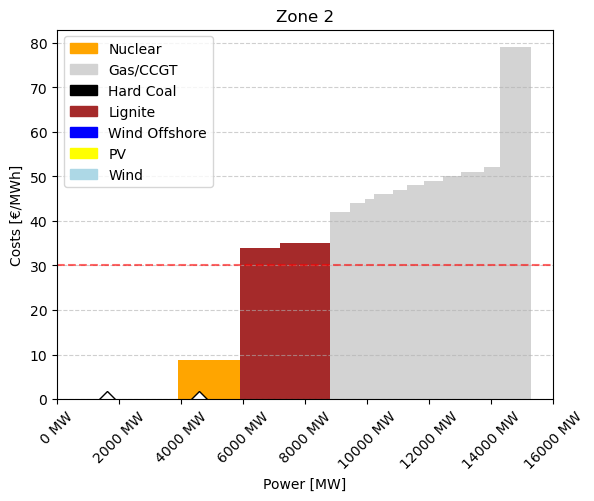

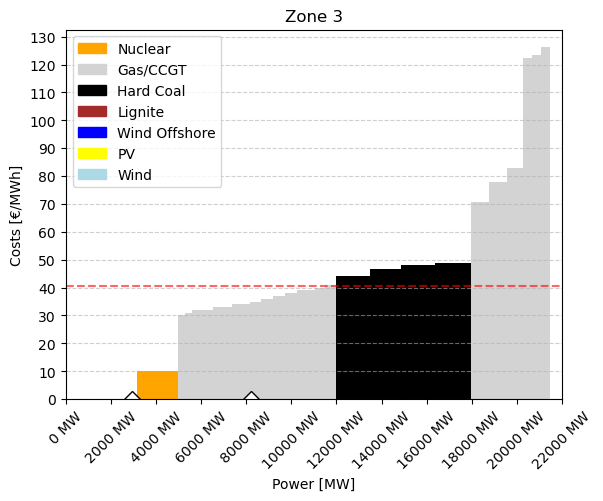

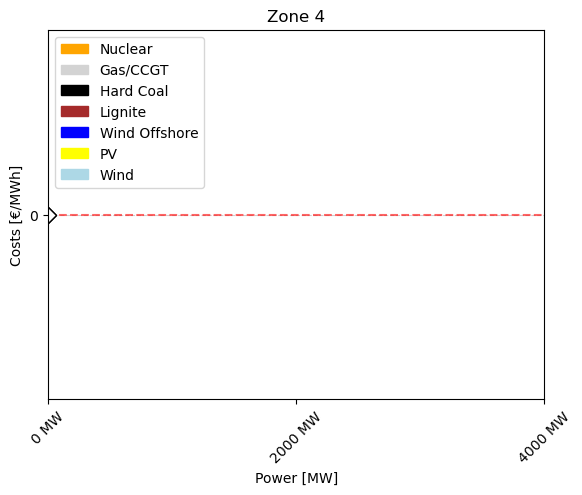

Zone 1:
  Conventional Generation Capacity: 14837.0 MW
  Renewable Generation Capacity: 1615.0 MW
  Max Hourly Load: 13544.91 MW
  Min Hourly Load: 4810.24 MW
Zone 2:
  Conventional Generation Capacity: 11410.0 MW
  Renewable Generation Capacity: 3891.0 MW
  Max Hourly Load: 4575.06 MW
  Min Hourly Load: 1624.76 MW
Zone 3:
  Conventional Generation Capacity: 18317.3 MW
  Renewable Generation Capacity: 3157.0 MW
  Max Hourly Load: 8220.69 MW
  Min Hourly Load: 2919.46 MW
Zone 4:
  Conventional Generation Capacity: 0.0 MW
  Renewable Generation Capacity: 3000.0 MW
  Max Hourly Load: 0 MW
  Min Hourly Load: 0 MW


In [9]:


# Step 1: Read both data files
gen_data = pd.read_csv('gen_info.csv', delimiter=';')
node_data = pd.read_csv('node_info.csv', delimiter=';')

# Step 2: Merge the datasets on node/bus ID to map each generator to its zone
merged_data = pd.merge(gen_data, node_data, left_on='OnBus', right_on='BusID')

# Step 3: Group data by Zone, and sort each group by Costs
grouped_data = merged_data.groupby('Zone')
sorted_grouped_data = {zone: group.sort_values(by='Costs') for zone, group in grouped_data}

# Custom color dictionary based on generator type
color_dict = {
    'Nuclear': 'orange',
    'Gas/CCGT': 'lightgrey',
    'Hard Coal': 'black',
    'Lignite': 'brown',
    'Wind Offshore': 'blue',
    'PV': 'yellow',
    'Wind': 'lightblue'
}

# Helper function to plot data
def plot_data(data, title, min_load, max_load):
    if data.empty:
        print(f"No data available for {title}")
        return

    fig, ax = plt.subplots()
    positions = data['Pmax'].cumsum().shift(1).fillna(0)
    handles = []

    for pos, (pmax, cost, typ) in zip(positions, zip(data['Pmax'], data['Costs'], data['Type'])):
        bar = ax.bar(pos + pmax / 2, cost, width=pmax, color=color_dict[typ], align='center')
        handles.append(bar)

    max_pmax = data['Pmax'].cumsum().max()
    ax.set_xlim(0, max_pmax)
    ax.set_xticks(range(0, int(max_pmax + 2000), 2000))
    ax.set_xticklabels([f'{x} MW' for x in range(0, int(max_pmax + 2000), 2000)])
    ax.set_yticks(range(0, int(data['Costs'].max() + 10), 10))
    plt.xticks(rotation=45)
    ax.set_xlabel('Power [MW]')
    ax.set_ylabel('Costs [€/MWh]')

    weighted_avg_cost = (data['Pmax'] * data['Costs']).sum() / data['Pmax'].sum()
    ax.axhline(weighted_avg_cost, color='red', linestyle='--', alpha =0.6)

    ax.plot(min_load, 0, marker='D', color='black', markerfacecolor='white', markeredgewidth=1, markersize=8)
    ax.plot(max_load, 0, marker='D', color='black', markerfacecolor='white', markeredgewidth=1, markersize=8)
 # Create legend
    patches = [matplotlib.patches.Patch(color=v, label=k) for k, v in color_dict.items()]
    plt.legend(handles=patches, loc='upper left')
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)
    plt.title(title)
    plt.show()

load_values = {
    1: {'min': 4810.24, 'max': 13544.91},
    2: {'min': 1624.76, 'max': 4575.06},
    3: {'min': 2919.46, 'max': 8220.69},
    4: {'min': 0, 'max': 0},
}

# #IF schon x1.5
# load_values = {
#     1: {'min': 7922.625, 'max': 20317.37},
#     2: {'min': 2437.14, 'max': 6862.59},
#     3: {'min': 17565.44, 'max': 20612.82},
#     4: {'min': 0, 'max': 0},
# }


# Step 8: Plot for each zone
for zone, data in sorted_grouped_data.items():
    plot_data(data, f'Zone {zone}', load_values[zone]['min'], load_values[zone]['max'])

    # Define the types of generators
conventional_generators = ['Nuclear', 'Gas/CCGT', 'Hard Coal', 'Lignite']
renewable_generators = ['PV', 'Wind', 'Wind Offshore']

# Initialize dictionaries to store the results
conventional_capacity = {}
renewable_capacity = {}

# Calculate the total installed capacity for each type of generator in each zone
for zone, data in sorted_grouped_data.items():
    conventional_capacity[zone] = data[data['Type'].isin(conventional_generators)]['Pmax'].sum()
    renewable_capacity[zone] = data[data['Type'].isin(renewable_generators)]['Pmax'].sum()

# Print the results
for zone in sorted_grouped_data.keys():
    print(f"Zone {zone}:")
    print(f"  Conventional Generation Capacity: {conventional_capacity[zone]} MW")
    print(f"  Renewable Generation Capacity: {renewable_capacity[zone]} MW")
    print(f"  Max Hourly Load: {load_values[zone]['max']} MW")
    print(f"  Min Hourly Load: {load_values[zone]['min']} MW")


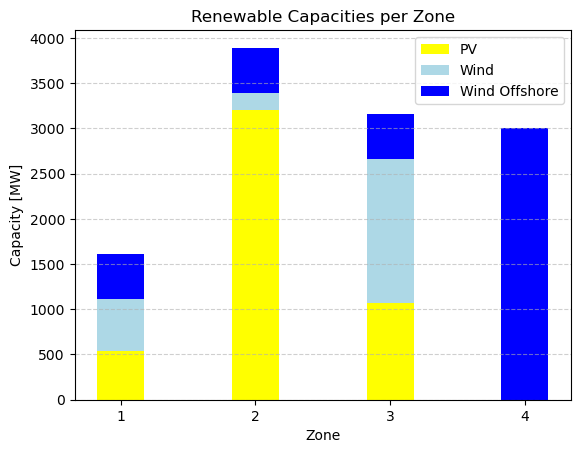

In [10]:
#Renewable Capacities per zone
def plot_renewable_capacities(data_dict, title):
    # Define the renewable types
    renewable_types = ['PV', 'Wind', 'Wind Offshore']

    # Initialize a dictionary to hold the data
    renewable_data = {rtype: [] for rtype in renewable_types}
    zones = []

    # Loop over each zone
    for zone, data in data_dict.items():
        zones.append(zone)
        for rtype in renewable_types:
            # Sum the Pmax for the renewable type in the current zone
            renewable_data[rtype].append(data[data['Type'] == rtype]['Pmax'].sum())

    # Plot the data
    fig, ax = plt.subplots()
    bar_width = 0.35
    index = np.arange(len(zones))

    cum_values = np.zeros(len(zones))
    for rtype, values in renewable_data.items():
        ax.bar(index, values, bar_width, bottom=cum_values, color=color_dict[rtype], label=rtype)
        cum_values += values

    ax.set_xlabel('Zone')
    ax.set_ylabel('Capacity [MW]')
    ax.set_title(title)
    ax.set_xticks(index)
    ax.set_xticklabels(zones)
    ax.legend()
    ax.grid(True, axis='y', linestyle='--', alpha=0.6)

    plt.show()

# Call the function
plot_renewable_capacities(sorted_grouped_data, 'Renewable Capacities per Zone')